# Perform clustering on Olivetti faces dataset

## Import the dataset and visualise

In [21]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

Image size (64, 64)


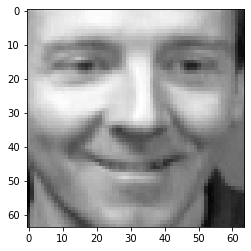

In [43]:
import matplotlib.pyplot as plt

example_image_num = 20

print('Image size', faces['images'][example_image_num].shape)

plt.imshow(faces['images'][example_image_num], cmap='gray')
plt.show()

In [52]:
print('Image flatterned shape:\n', faces['data'][example_image_num].shape)
print('\nImage identifiers:\n', faces['target'])

Image flatterned shape:
 (4096,)

Image identifiers:
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 

## Split the dataset into train & test
### Need to shuffle as images are ordered by person

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(faces['data'], 
                                                            faces['target'], 
                                                            test_size=0.2,
                                                            stratify=faces['target'])
X_val, X_test, y_val, y_test = train_test_split(X_val_test, 
                                                y_val_test, 
                                                test_size=0.5,
                                                stratify=y_val_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(320, 4096) (320,)
(40, 4096) (40,)
(40, 4096) (40,)


## Cluster the dataset
### Choose the best number of clusters

In [104]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

clusters = np.arange(10, 300, 30)
inertias = []
silhouettes = []

for cluster in clusters:
    kmc = KMeans(n_clusters=cluster)
    kmc.fit(X_train)
    inertias.append(kmc.inertia_)
    silhouettes.append(silhouette_score(X_train, kmc.labels_))

Text(0.5, 1.0, '# clusters choice from inertia')

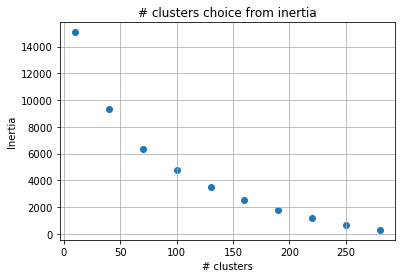

In [105]:
plt.scatter(clusters, inertias)
plt.xlabel('# clusters')
plt.ylabel('Inertia')
plt.grid(which='both')
plt.title('# clusters choice from inertia')

Text(0.5, 1.0, '# clusters choice from silhouettes')

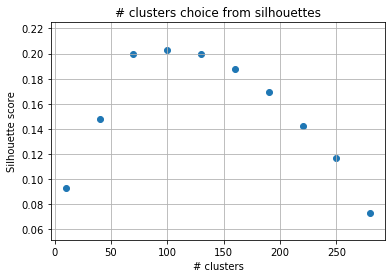

In [106]:
plt.scatter(clusters, silhouettes)
plt.xlabel('# clusters')
plt.ylabel('Silhouette score')
plt.grid(which='both')
plt.title('# clusters choice from silhouettes')

### Re train the model using the best cluster number

In [109]:
kmc = KMeans(clusters[np.argmax(silhouettes)])
kmc.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

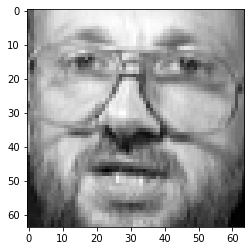

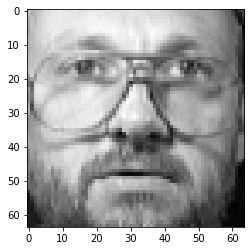

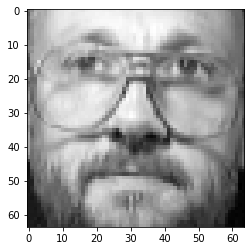

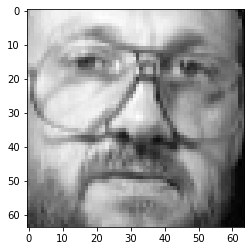

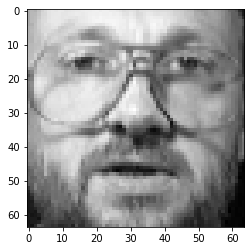

In [113]:
a_cluster_index = 30

for flat_image in X_train[np.where(kmc.labels_ == a_cluster_index)]:
    plt.imshow(flat_image.reshape(64, 64), cmap='gray')
    plt.show()

# Train a classifier

In [115]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
lrc.fit(X_train, y_train)

/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
lrc.score(X_val, y_val)

0.95

## Use kmeans for dimensionality reduction

### Use kmeans to find distance to cluster centers, then use logistic regression

In [119]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('clustering', KMeans(clusters[np.argmax(silhouettes)])),
    ('log_reg', LogisticRegression())    
])

pipeline.fit(X_train, y_train)

/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('clustering',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=100, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [120]:
pipeline.score(X_val, y_val)

0.925

## Perform a search over number of clusters to use

In [127]:
from sklearn.model_selection import GridSearchCV

param_grid = {'clustering__n_clusters': np.arange(10, 150, 30)}
grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this w

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clustering',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=100, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=None, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_interce...,
   

In [129]:
print(grid_clf.best_params_)
grid_clf.score(X_val, y_val)

{'clustering__n_clusters': 130}


0.95

## Add the cluster distances to the feature set & retrain

## STILL TODO

In [130]:
X_train.shape

(320, 4096)

In [ ]:
pipeline_2 = Pipeline([
    ('predict_cluster', KMeans(clusters[np.argmax(silhouettes)])),
    ('log_reg', LogisticRegression()) 
])

In [134]:
X_train_with_cluster_dist = np.c_[X_train, pipeline['clustering'].labels_]
X_train_with_cluster_dist.shape

(320, 4097)

In [135]:
lrc = LogisticRegression()
lrc.fit(X_train_with_cluster_dist, y_train)

/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sean/anaconda3/envs/hands_on_machine_learning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
lrc.score(X_val, y_val)

ValueError: X has 4096 features per sample; expecting 4097